In [133]:
import numpy as np
import matplotlib.pyplot as plt

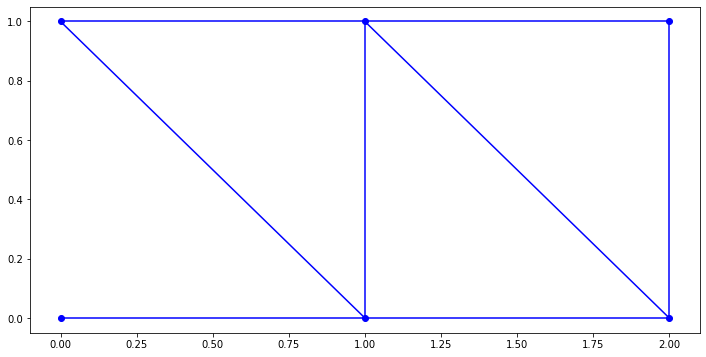

In [134]:
# --- Mesh definition ---
# Defining a truss manually

nodes = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [2, 0],
    [2, 1]
])

elems = np.array([
    [0, 2],
    [1, 2],
    [1, 3],
    [2, 3],
    [2, 4],
    [3, 4],
    [3, 5],
    [4, 5]
])

def plot(ax, nodes, elems, c):
    '''Plot nodes and elements'''
    ax.plot(nodes[:, 0], nodes[:, 1], 'o'+c)
    for elem in elems:
        pair = np.array([nodes[elem[0]], nodes[elem[1]]])
        ax.plot(pair[:, 0], pair[:, 1], '-'+c)

fig, ax = plt.subplots(1, figsize=(12, 6))
plot(ax, nodes, elems, 'b')
plt.show()


In [135]:
# --- Element specific stiffness matrix formulation ---
# Method of weighted residuals generalises this

dof = 2 # Node dof

def rot(cos_t, sin_t) -> np.ndarray:
    '''Returns rotation matrix for bar element'''
    return np.array([
        [cos_t, sin_t, 0, 0],
        [0, 0, sin_t, cos_t]
        ])

# Element stiffness matrix in local coordinate system
K_loc = np.array([
    [1, -1],
    [-1, 1]
])

print(np.round(K_loc@rot(np.cos(45), np.sin(45)), 2))

[[ 0.53  0.85 -0.85 -0.53]
 [-0.53 -0.85  0.85  0.53]]


In [136]:
# --- System Assembly ---

def stiffness(nodes, elems, A=1, E=1):

    A, E = 1, 1

    gdof = dof*len(nodes)
    K_glob = np.zeros((gdof, gdof)) # Global stiffness matrix

    for elem in elems:

        v = nodes[elem][0] - nodes[elem][1] # Vector between nodes of element
        L = np.linalg.norm(v) # Norm 
        c = v[0]/L # cos(theta)
        s = v[1]/L # sin(theta)

        rot_elem = rot(c, s)
        k_elem_glob = (1/L) * rot_elem.T@K_loc@rot_elem # Element stiffness matrix in global coordinate system

        # Distribute element stiffness matrix onto corresponding notes in global stiffness matrix
        for a, i in enumerate(elem):
            for b, j in enumerate(elem):
                K_glob[dof*i:dof*(i+1), dof*j:dof*(j+1)] += k_elem_glob[dof*a:dof*(a+1), dof*b:dof*(b+1)]

        K_glob *= A*E # Assuming bars have same cross sectional area and Young's modulus

    return K_glob

K_glob = stiffness(nodes, elems)
print(np.round((K_glob), 2))

[[ 1.    0.    0.    0.    0.   -1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.35 -0.35  0.35 -0.35  0.   -1.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.35  0.35 -0.35  0.35  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.35 -0.35  1.35 -0.35  0.    0.    0.   -1.    0.    0.  ]
 [-1.    0.   -0.35  0.35 -0.35  2.35 -1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -1.    2.35 -0.35  0.35 -0.35  0.   -1.  ]
 [ 0.    0.   -1.    0.    0.    0.   -0.35  1.35 -0.35  0.35  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.35  0.35 -0.35  0.    0.  ]
 [ 0.    0.    0.    0.   -1.    0.   -0.35  0.35 -0.35  2.35 -1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -1.    0.    0.    0.    0.    1.  ]]


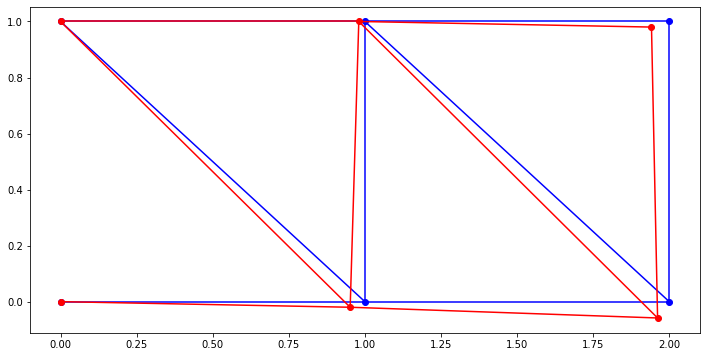

In [137]:
# --- Boundary Conditions + Solving ---

forces = np.array([0, 0, 0, 0, 0, -0.01, 0, 0, 0, -0.01, 0, 0])
u = np.zeros_like(forces)
constraints = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=bool)

# Omit rows + columns of constrained nodes and solve
u[constraints] = np.linalg.solve(K_glob[constraints].T[constraints], forces[constraints])

u = u.reshape(-1, 2) # Reshape column vector into shape of nodes array

fig, ax = plt.subplots(1, figsize=(12, 6))

plot(ax, nodes, elems, 'b')
plot(ax, nodes + u, elems, 'r')
plt.show()

In [138]:
# --- Finding the stresses in the elements ---

def length(nodes, elem):
    v = nodes[elem][0] - nodes[elem][1]
    return np.linalg.norm(v)

def stress(nodes, elems):
    stress = []
    for elem in elems:
        stress.append(length(u, elem)/length(nodes, elem)) # delta L / L
        print(elem, stress[-1])
    return np.array(stress)

stress(nodes, elems)

[0 2] 0.052262518595054964
[1 2] 0.0369551813004514
[1 3] 0.019999999999999966
[2 3] 0.034641016151377484
[2 4] 0.03956874302968483
[3 4] 0.04319358083036449
[3 5] 0.04319358083036449
[4 5] 0.043193580830364495


array([0.05226252, 0.03695518, 0.02      , 0.03464102, 0.03956874,
       0.04319358, 0.04319358, 0.04319358])

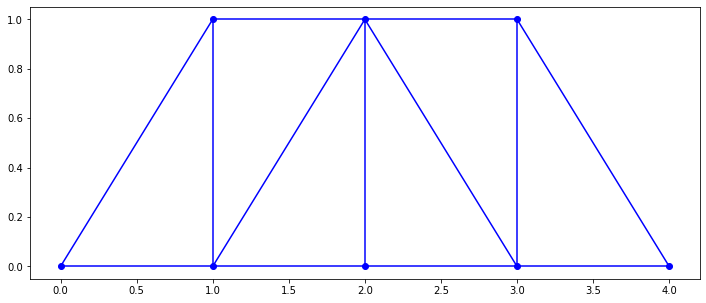

In [139]:
# --- More complex truss ---

nodes = np.array([
    [0, 0],
    [1, 0],
    [1, 1],
    [2, 0],
    [2 ,1],
    [3, 0],
    [3, 1],
    [4, 0]
])

elems = np.array([
    [0, 1],
    [0, 2],
    [1, 2],
    [1, 3],
    [1, 4],
    [2, 4],
    [3, 4],
    [3, 5],
    [4, 5],
    [4, 6],
    [5, 6],
    [5, 7],
    [6, 7]
])


fig, ax = plt.subplots(1, figsize=(12, 5))
plot(ax, nodes, elems, 'b')
plt.show()

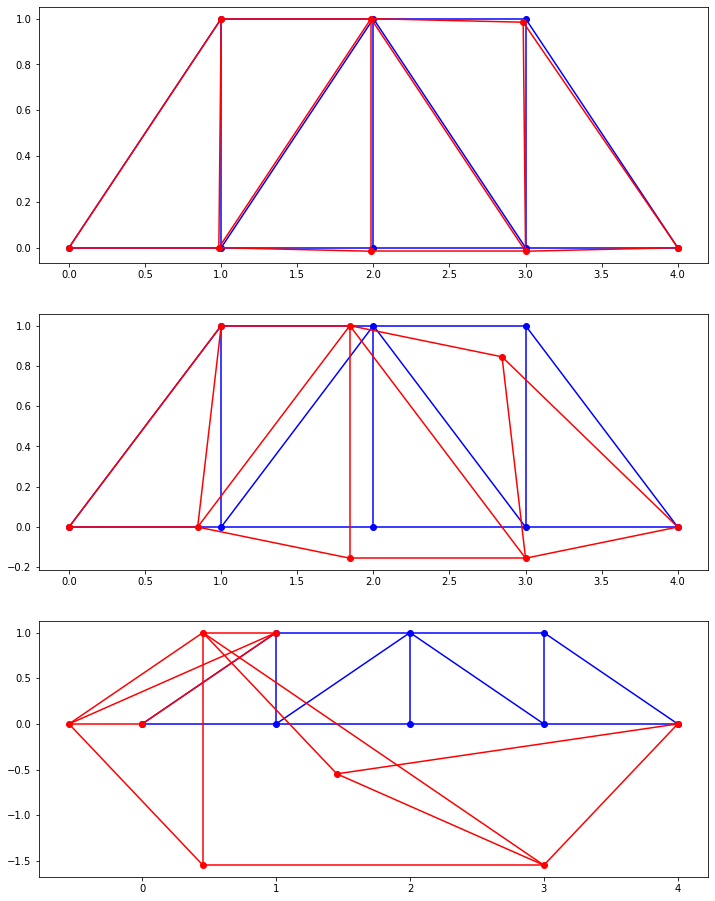

In [140]:
# --- Solving with three different forces on the bottom middle node --- 

K_glob = stiffness(nodes, elems)

constraints = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=bool)
forces = np.array([0, 0, 0, 0, 0, 0, 0, -0.00000000000000001, 0, 0, 0, 0, 0, 0, 0, 0])

fig, ax = plt.subplots(3, figsize=(12, 16))

for i in range(3):

    u = np.zeros_like(forces)
    u[constraints] = np.linalg.solve(K_glob[constraints].T[constraints], forces[constraints]*(10**i))
    u = u.reshape(-1, 2)

    plot(ax[i], nodes, elems, 'b')
    plot(ax[i], nodes + u, elems, 'r')

plt.show()

# This is clearly very unstable, something has to be wrong